In [1]:
!pip install kaggle

In [2]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"nadavtoledo1","key":"c2c6f0bc23c634022c5d4c2c13e88490"}'}

In [3]:
!mkdir -p ~/.kaggle
!mv kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json


In [4]:
!kaggle datasets download -d jutrera/stanford-car-dataset-by-classes-folder


Dataset URL: https://www.kaggle.com/datasets/jutrera/stanford-car-dataset-by-classes-folder
License(s): other
100% 1.83G/1.83G [00:12<00:00, 164MB/s]
100% 1.83G/1.83G [00:12<00:00, 151MB/s]


In [5]:
import zipfile
with zipfile.ZipFile("stanford-car-dataset-by-classes-folder.zip", "r") as zip_ref:
    zip_ref.extractall("stanford_cars")


In [6]:
import os
import matplotlib.pyplot as plt
from PIL import Image
import pandas as pd
from tqdm import tqdm
import random


In [7]:
os.listdir('stanford_cars')

['anno_train.csv', 'car_data', 'names.csv', 'anno_test.csv']

In [20]:
train = "/content/stanford_cars/car_data/car_data/train"
test = "/content/stanford_cars/car_data/car_data/test"
train_annotations_path = '/content/stanford_cars/anno_train.csv'
cropped_images_path = "/content/stanford_cars/cropped_images"

# Create the output directory if it doesn't exist
os.makedirs(cropped_images_path, exist_ok=True)

# Read the annotation file
train_annotations = pd.read_csv(
    train_annotations_path,
    header=None,  # No headers in the file
    names=["image_name", "x_min", "y_min", "x_max", "y_max", "class_id"]
)

# Function to find the full path of an image and its car model name
def find_image_path_and_model(image_name, train_images_path):
    for root, dirs, files in os.walk(train_images_path):
        if image_name in files:
            car_model = os.path.basename(root)  # Extract folder name (car model)
            return os.path.join(root, image_name), car_model
    return None, None

# Loop through all annotations
for index, row in tqdm(train_annotations.iterrows(), total=len(train_annotations)):
    # Extract annotation details
    image_name = row["image_name"]
    bbox_xmin = row["x_min"]
    bbox_ymin = row["y_min"]
    bbox_xmax = row["x_max"]
    bbox_ymax = row["y_max"]

    # Find the full path to the image and its car model name
    image_path, car_model = find_image_path_and_model(image_name, train)

    if image_path:
        try:
            # Open and crop the image
            image = Image.open(image_path)
            cropped_image = image.crop((bbox_xmin, bbox_ymin, bbox_xmax, bbox_ymax))

            # Save the cropped image in a folder named after the car model
            model_dir = os.path.join(cropped_images_path, car_model)
            os.makedirs(model_dir, exist_ok=True)  # Create model directory if it doesn't exist
            cropped_image_path = os.path.join(model_dir, image_name)
            cropped_image.save(cropped_image_path)

        except Exception as e:
            print(f"Error processing {image_name}: {e}")
    else:
        print(f"Image not found: {image_name}")

print("Cropped dataset creation complete!")

# Read the CSV file
train_annotations = pd.read_csv(
    train_annotations_path,
    header=None,  # No headers in the file
    names=["image_name", "x_min", "y_min", "x_max", "y_max", "class_id"]
)
test_annotations_path = '/content/stanford_cars/anno_test.csv'
test_annotations = pd.read_csv(test_annotations_path)

# Create a dictionary to map class_id to car model names
id_to_model_dict = {}
model_to_id_dict = {}

# Iterate over subfolders in the training images path
for class_id, folder_name in enumerate(sorted(os.listdir(train)), start=1):
    id_to_model_dict[class_id] = folder_name
    model_to_id_dict[folder_name] = class_id

100%|██████████| 8144/8144 [01:54<00:00, 71.20it/s]


Cropped dataset creation complete!


# 1)

## a.

In [21]:
print(f"Total number of training images: {len(train_annotations)}")
print(f"Total number of test images: {len(test_annotations)}")
print(f"Number of unique classes: {len(id_to_model_dict)}")

Total number of training images: 8144
Total number of test images: 8040
Number of unique classes: 196


## b.

### Sample Structure
Each sample in the dataset contains:

Image file: High-resolution RGB image.\
Bounding box: (x_min, y_min, x_max, y_max) coordinates for cropping the car.\
Class ID: Label for the car model (1-196).
### Preprocessing and Augmentation
Preprocessing: Cropping the images to the bounding box and resizing to a uniform size (e.g., 224x224).\
Augmentation :
Random rotations and flips. \
Color adjustments (brightness, contrast, hue).

## c.

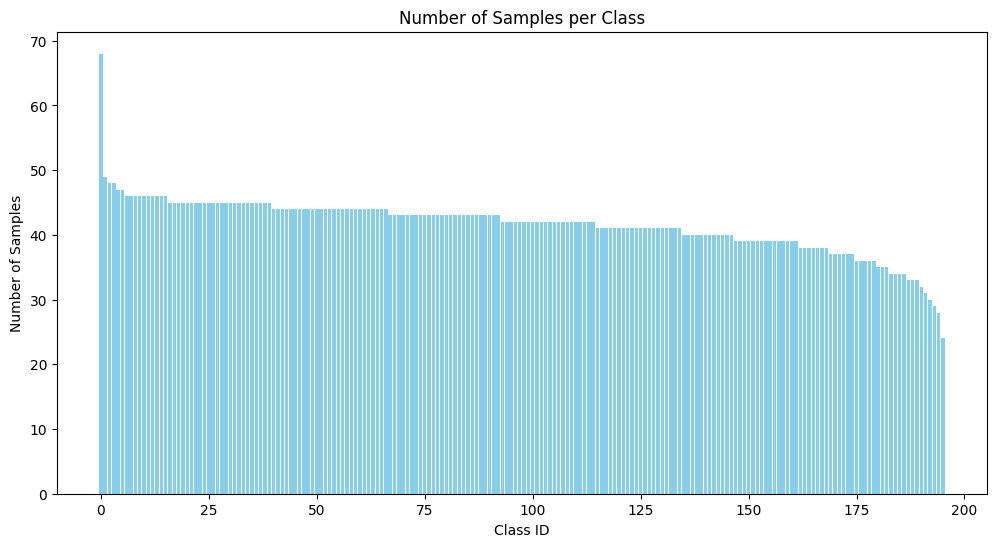

Min samples per class: 24, Max samples per class: 68, Avarege samples per class: 41.55102040816327, Median samples per class: 42.0


In [22]:
# Count samples per class
class_counts = train_annotations["class_id"].value_counts()
plt.figure(figsize=(12, 6))
plt.bar(range(len(class_counts)), class_counts.values, color="skyblue")
plt.title("Number of Samples per Class")
plt.xlabel("Class ID")
plt.ylabel("Number of Samples")
plt.show()

# Check if balanced
min_samples = class_counts.min()
max_samples = class_counts.max()
avg_samples = class_counts.mean()
med_samples = class_counts.median()
print(f"Min samples per class: {min_samples}, Max samples per class: {max_samples}, Avarege samples per class: {avg_samples}, Median samples per class: {med_samples}")


## d.

### Benchmark Results
The Stanford Cars dataset has been used in various methods for image classification. Benchmarks include:

**Convolutional Neural Networks (CNNs):**\
ResNet-50: Top-1 Accuracy ≈ 92.5% \
VGG-16: Top-1 Accuracy ≈ 89.7% \
**Vision Transformers (ViT):** \
ViT-B/16: Top-1 Accuracy ≈ 94.6% \
- Fine-tuning pretrained models has shown to significantly improve performance.

## e.

<ipython-input-23-d298d62b36f9>:15: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  for idx, class_id in enumerate(random.sample(id_to_model_dict.keys(), len(axes))):


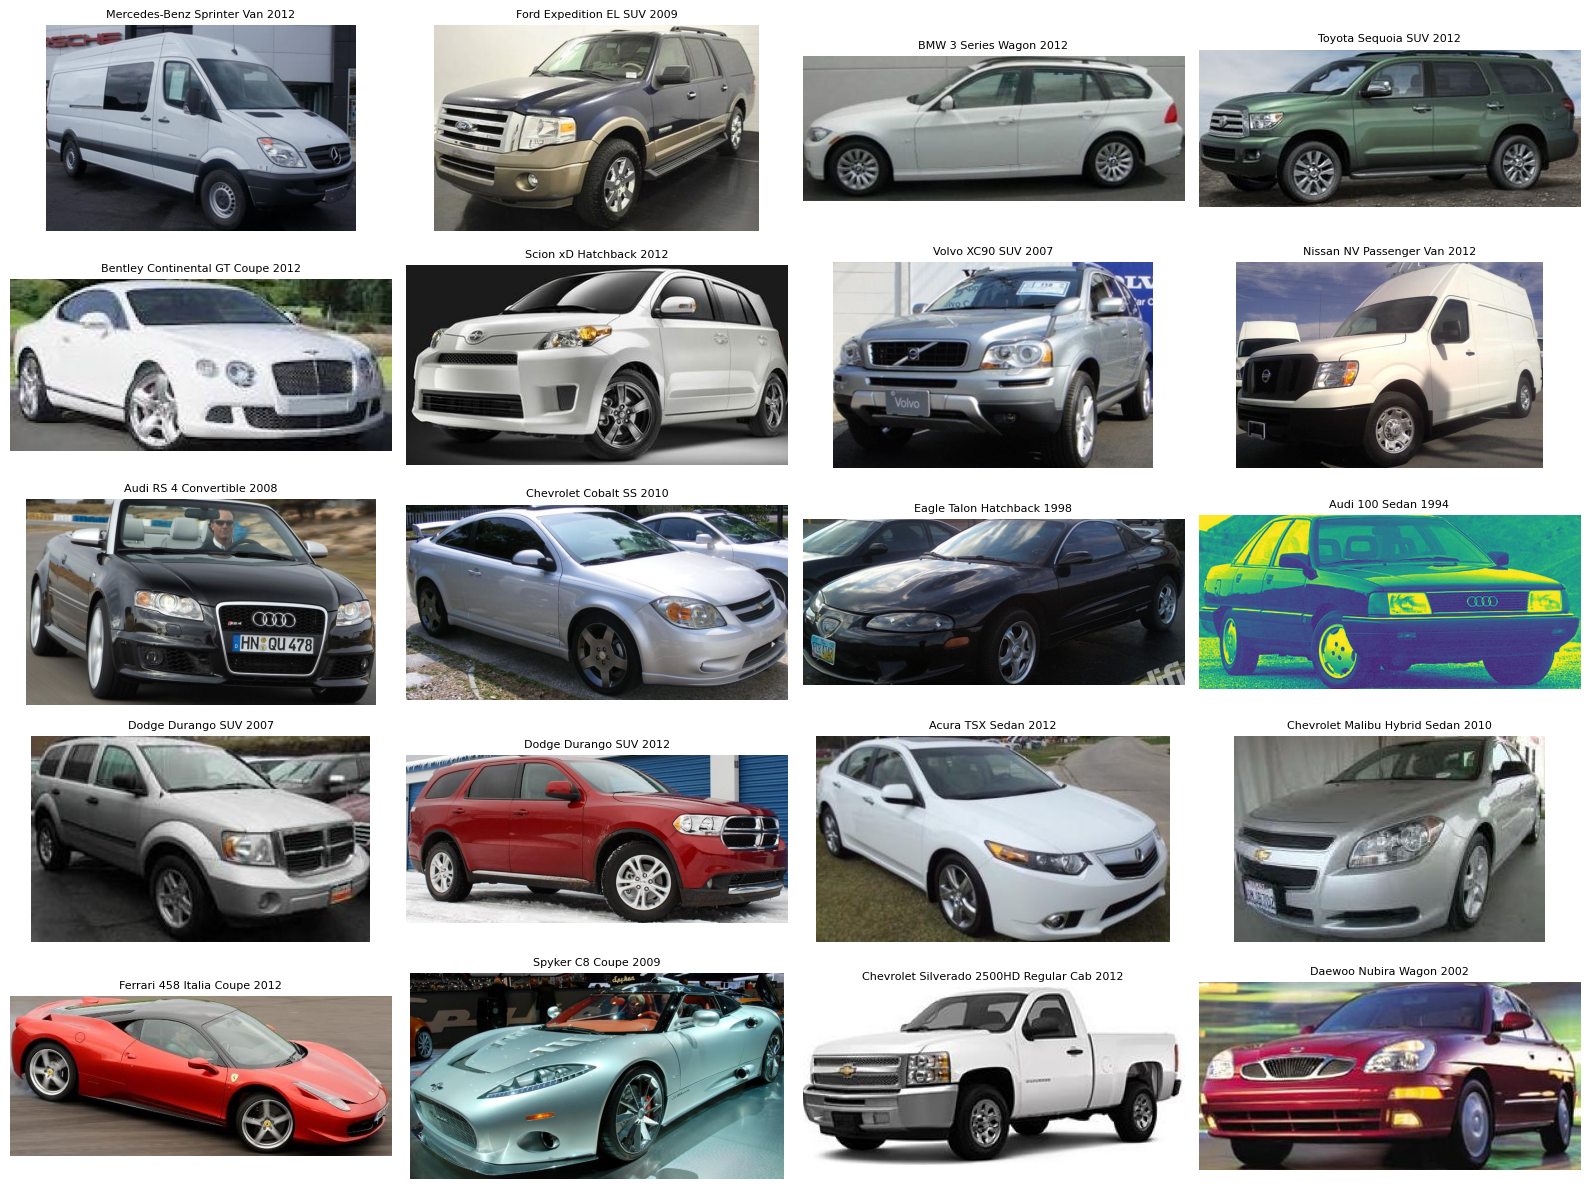

In [23]:
def show_samples_per_class(id_to_model_dict, cropped_images_path, n_samples=5):
    """
    Display samples from each class in the dataset.

    Args:
    - id_to_model_dict: Dictionary mapping class IDs to car model names.
    - cropped_images_path: Path to the folder containing cropped images by class ID.
    - n_samples: Number of samples to display for each class.
    """
    # Create a subplot with 5 rows and 4 columns (adjust as needed)
    fig, axes = plt.subplots(n_samples, 4, figsize=(16, 12))
    axes = axes.flatten()

    # Loop through a few random classes and show samples
    for idx, class_id in enumerate(random.sample(id_to_model_dict.keys(), len(axes))):
        # Get the car model name from the id_to_model_dict
        class_name = id_to_model_dict[class_id]

        # Map the folder (class_id) to the name, assuming class ID is the folder name
        class_folder = os.path.join(cropped_images_path, str(class_name))  # Folder is by class ID

        # Check if the folder exists
        if not os.path.exists(class_folder):
            axes[idx].axis('off')
            axes[idx].set_title(f"Folder not found: {class_name}", fontsize=8)
            continue

        # Get a random image from the folder
        try:
            image_files = os.listdir(class_folder)
            if len(image_files) == 0:
                axes[idx].axis('off')
                axes[idx].set_title(f"No images in {class_name}", fontsize=8)
                continue

            # Select a random image
            sample_image = os.path.join(class_folder, random.choice(image_files))

            # Open the image
            image = Image.open(sample_image)

            # Show the image
            axes[idx].imshow(image)
            axes[idx].axis('off')
            axes[idx].set_title(class_name, fontsize=8)
        except Exception as e:
            # Handle potential errors (e.g., opening images)
            axes[idx].axis('off')
            axes[idx].set_title(f"Error: {e}", fontsize=8)

    plt.tight_layout()
    plt.show()

# Example usage:
show_samples_per_class(id_to_model_dict, cropped_images_path="/content/stanford_cars/cropped_images", n_samples=5)

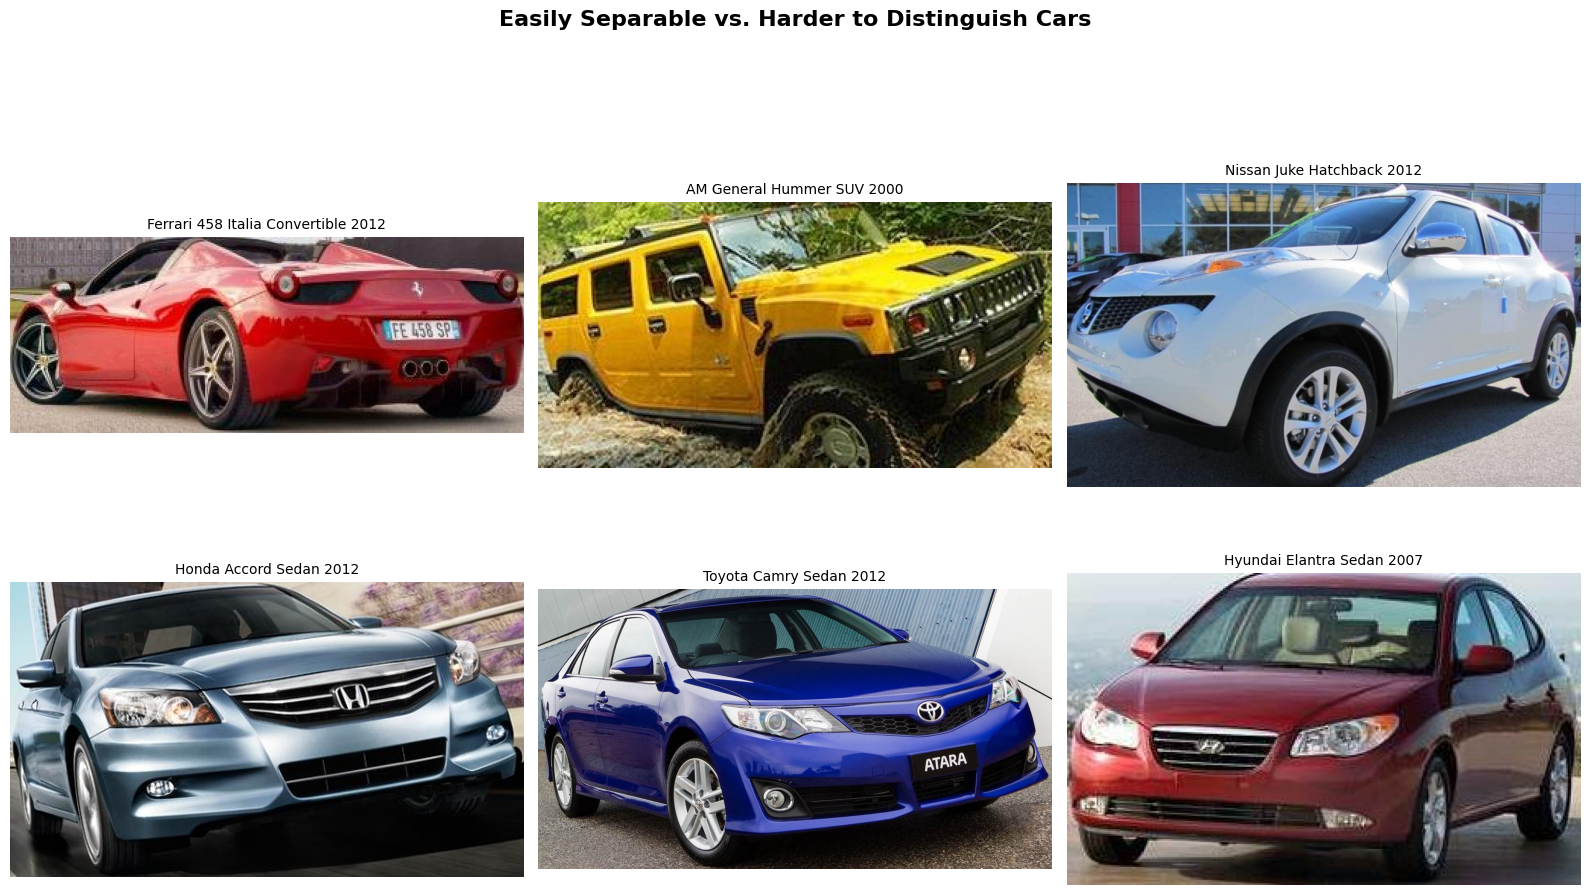

In [24]:
def show_separable_vs_similar(id_to_model_dict, cropped_images_path, n_samples=5):
    """
    Display specific samples from easily separable and harder-to-distinguish categories.

    Args:
    - id_to_model_dict: Dictionary mapping class IDs to car model names.
    - cropped_images_path: Path to the folder containing cropped images by class ID.
    - n_samples: Number of samples to display for each category (optional, defaults to 5).
    """
    # Predefined car models for the two categories
    easily_separable_models = [
        "Ferrari 458 Italia Convertible 2012",
        "AM General Hummer SUV 2000",
        "Nissan Juke Hatchback 2012"
    ]
    harder_to_distinguish_models = [
        "Honda Accord Sedan 2012",
        "Toyota Camry Sedan 2012",
        "Hyundai Elantra Sedan 2007"
    ]

    # Get corresponding class IDs for the selected car models
    easily_separable_classes = [
        class_id for class_id, model_name in id_to_model_dict.items()
        if model_name in easily_separable_models
    ]
    harder_classes = [
        class_id for class_id, model_name in id_to_model_dict.items()
        if model_name in harder_to_distinguish_models
    ]

    # Set up subplots
    fig, axes = plt.subplots(2, len(easily_separable_models), figsize=(16, 10))

    # Set titles for categories
    fig.suptitle("Easily Separable vs. Harder to Distinguish Cars", fontsize=16, fontweight="bold")
    for ax, category in zip(axes[:, 0], ["Easily Separable Cars", "Harder to Distinguish Cars"]):
        ax.set_ylabel(category, fontsize=12, fontweight="bold")

    # Function to display specific car models
    def display_images(class_ids, model_names, row_idx):
        for idx, (class_id, model_name) in enumerate(zip(class_ids, model_names)):
            if class_id is None:
                # Skip if the model is not found in the dictionary
                axes[row_idx, idx].axis('off')
                axes[row_idx, idx].set_title(f"{model_name}\nNot Found", fontsize=8)
                continue

            # Path to the folder containing images of the class
            class_folder = os.path.join(cropped_images_path, str(model_name))
            if not os.path.exists(class_folder):
                axes[row_idx, idx].axis('off')
                axes[row_idx, idx].set_title(f"{model_name}\nFolder Not Found", fontsize=8)
                continue

            try:
                # Get a random image from the folder
                image_files = os.listdir(class_folder)
                if len(image_files) == 0:
                    axes[row_idx, idx].axis('off')
                    axes[row_idx, idx].set_title(f"{model_name}\nNo Images Found", fontsize=8)
                    continue

                sample_image = os.path.join(class_folder, random.choice(image_files))
                image = Image.open(sample_image)

                # Display the image
                axes[row_idx, idx].imshow(image)
                axes[row_idx, idx].axis('off')
                axes[row_idx, idx].set_title(model_name, fontsize=10)
            except Exception as e:
                axes[row_idx, idx].axis('off')
                axes[row_idx, idx].set_title(f"{model_name}\nError: {e}", fontsize=8)

    # Display images for both categories
    display_images(easily_separable_classes, easily_separable_models, row_idx=0)
    display_images(harder_classes, harder_to_distinguish_models, row_idx=1)

    plt.tight_layout(rect=[0, 0, 1, 0.95])  # Adjust layout to fit title
    plt.show()

# Example usage:
# Assuming `id_to_model_dict` maps IDs to car model names and `cropped_images_path` is the path to the dataset
show_separable_vs_similar(
    id_to_model_dict=id_to_model_dict,
    cropped_images_path="/content/stanford_cars/cropped_images",
    n_samples=3
)

